# Data Clustering and Segmentation Analysis
## Robust k-medoids in Action - Part 3 Model Testing
<b>Author:</b> Jacob Cybulski<br>
<b>Version:</b> V1.5, September 2019

<b>Data:</b> Ames Housing Dataset<br>
<b>Prepared by:</b> Dean De Cock, <a href="http://jse.amstat.org/v19n3/decock.pdf" target="new">"Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project"</a>, Journal of Statistics Education, Volume 19, Number 3(2011). With <a href="http://jse.amstat.org/v19n3/decock/AmesHousing.txt" target="new">data</a> and <a href="http://jse.amstat.org/v19n3/decock/DataDocumentation.txt" target="new">description</a>.<br>
<b>Kaggle URL:</b> https://www.kaggle.com/prevek18/ames-housing-dataset 

<b>Challenge Data:</b> Melbourne Real Estate Dataset<br>
<b>Kaggle URL:</b> https://www.kaggle.com/anthonypino/melbourne-housing-market

<b>Problem:</b> Apply previously applied clustering process to new (test) data using previously saved models.

<b>Method:</b> Feature Engineering, k-Medoids, PCA, Visualisation, Diagnostics, Segmentation Analysis

In [1]:
# install.packages("caret", dependencies = TRUE, repos="http://cran.us.r-project.org")
# install.packages("ggplot2", dependencies = TRUE, repos="http://cran.us.r-project.org")
# install.packages("psych", dependencies = TRUE, repos="http://cran.us.r-project.org")
# install.packages("car", dependencies = TRUE, repos="http://cran.us.r-project.org")
# install.packages("cluster", dependencies = TRUE, repos="http://cran.us.r-project.org")
# install.packages("factoextra", dependencies = TRUE, repos="http://cran.us.r-project.org")
# install.packages("tidyr", dependencies = TRUE, repos="http://cran.us.r-project.org")
# install.packages("alluvial", dependencies = TRUE, repos="http://cran.us.r-project.org")
# install.packages("rospca", dependencies = TRUE, repos="http://cran.us.r-project.org")
# install.packages("stringr", dependencies = TRUE, repos="http://cran.us.r-project.org")

In [3]:
# Where are the libraries
.libPaths()

# Use only the following packages
require(caret) # preProcess
require(ggplot2) # ggplot
require(cluster) # pam, silhouette
require(factoextra) # fviz_nbclust, fviz_pca_ind, fviz_pca_var, fviz_add
require(alluvial) # alluvial
require(stringr) # str_replace_all

[1] "/home/jacob/R/x86_64-pc-linux-gnu-library/3.5" 
[2] "/home/jacob/anaconda3/envs/rstat/lib/R/library"

In [4]:
# Source utilities
source("clustering_101_util.r")

## Pre-load all models developed in training

In [5]:
impute.model <- readRDS("Models/rimpute_model.rds")
std.model <- readRDS("Models/rstd_model.rds")
cluster.model <- readRDS("Models/rcluster_model.rds")
robpca.model <- readRDS("Models/rpca_model.rds")
cat("All models have been recovered")

All models have been recovered

## Acquire test data
<i>Read the test data.</i>

In [6]:
# Read twst data from the CSV file
test.houses <- read.csv(file = "Data/AmesHousing-Test.csv", header = TRUE)
cat(paste("Test Data: ", nrow(test.houses), " observations"))

Test Data:  930  observations

<i>And prepare it in exactly the same way as in testing.</i>

In [7]:
# Deal with ID attributes
cat(ifelse(length(test.houses$PID) == length(unique(test.houses$PID)), 
      "All IDs are unique", "Some IDs are not unique"))
rownames(test.houses) <- test.houses$PID
test.houses <- subset(test.houses, select=-c(Order, PID, X))

All IDs are unique

## Selection and transformation of variables into numeric
<i>No encoding of categorical variables in this case,</i>

In [8]:
# Select only numeric variables
test.houses <- test.houses[,sapply(test.houses, is.numeric)]
colnames(test.houses)

[1] "MS_SubClass"     "Lot_Frontage"    "Lot_Area"        "Overall_Qual"   
 [5] "Overall_Cond"    "Year_Built"      "Year_Remod.Add"  "Mas_Vnr_Area"   
 [9] "BsmtFin_SF_1"    "BsmtFin_SF_2"    "Bsmt_Unf_SF"     "Total_Bsmt_SF"  
[13] "X1st_Flr_SF"     "X2nd_Flr_SF"     "Low_Qual_Fin_SF" "Gr_Liv_Area"    
[17] "Bsmt_Full_Bath"  "Bsmt_Half_Bath"  "Full_Bath"       "Half_Bath"      
[21] "Bedroom_AbvGr"   "Kitchen_AbvGr"   "TotRms_AbvGrd"   "Fireplaces"     
[25] "Garage_Yr_Blt"   "Garage_Cars"     "Garage_Area"     "Wood_Deck_SF"   
[29] "Open_Porch_SF"   "Enclosed_Porch"  "X3Ssn_Porch"     "Screen_Porch"   
[33] "Pool_Area"       "Misc_Val"        "Mo_Sold"         "Yr_Sold"        
[37] "SalePrice"

## Elimination of missing values

<i>Either missing values in test data should not be allowed or they must be eliminated using the model applied in trainig.</i>

In [9]:
# Impute missing values and check is any still left
cat("Percentage of missing values before imputation: ",
    round(mean(is.na(test.houses)), 3)*100, "%\n")
test.houses <- predict(impute.model, test.houses)
cat("Percentage of missing values after imputation: ",
    round(mean(is.na(test.houses)), 3)*100, "%")

Percentage of missing values before imputation:  0.6 %
Percentage of missing values after imputation:  0 %

## Variable standardisation

In [10]:
# Scale and center all variables using pre-loaded model
cat("Average SD before standardisation: ",
    mean(apply(test.houses, 2, sd)), "%\n")
std.houses <- predict(std.model, test.houses)
cat("Average SD after standardisation: ",
    mean(apply(std.houses, 2, sd)), "%\n\n")
cat('Standardised house properties: ', colnames(std.houses))

Average SD before standardisation:  2507.387 %
Average SD after standardisation:  0.9776583 %

Standardised house properties:  MS_SubClass Lot_Frontage Lot_Area Overall_Qual Overall_Cond Year_Built Year_Remod.Add Mas_Vnr_Area BsmtFin_SF_1 BsmtFin_SF_2 Bsmt_Unf_SF Total_Bsmt_SF X1st_Flr_SF X2nd_Flr_SF Low_Qual_Fin_SF Gr_Liv_Area Bsmt_Full_Bath Bsmt_Half_Bath Full_Bath Half_Bath Bedroom_AbvGr Kitchen_AbvGr TotRms_AbvGrd Fireplaces Garage_Yr_Blt Garage_Cars Garage_Area Wood_Deck_SF Open_Porch_SF Enclosed_Porch X3Ssn_Porch Screen_Porch Pool_Area Misc_Val Mo_Sold Yr_Sold SalePrice

## Use PCA model to select and transform variables

In [11]:
# Find the variable names from PCA loadings
sel.test.houses <- subset(std.houses, select=rownames(robpca.model$loadings))
cat('Selected house properties: ', colnames(sel.test.houses))
head(sel.test.houses, 3)

Selected house properties:  MS_SubClass Lot_Frontage Lot_Area Overall_Qual Overall_Cond Year_Built Year_Remod.Add Mas_Vnr_Area BsmtFin_SF_1 Bsmt_Unf_SF Total_Bsmt_SF X1st_Flr_SF X2nd_Flr_SF Gr_Liv_Area Bsmt_Full_Bath Full_Bath Half_Bath Bedroom_AbvGr TotRms_AbvGrd Fireplaces Garage_Yr_Blt Garage_Cars Garage_Area Wood_Deck_SF Open_Porch_SF Mo_Sold Yr_Sold SalePrice

,MS_SubClass,Lot_Frontage,Lot_Area,Overall_Qual,Overall_Cond,Year_Built,Year_Remod.Add,Mas_Vnr_Area,BsmtFin_SF_1,Bsmt_Unf_SF,⋯,TotRms_AbvGrd,Fireplaces,Garage_Yr_Blt,Garage_Cars,Garage_Area,Wood_Deck_SF,Open_Porch_SF,Mo_Sold,Yr_Sold,SalePrice
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
527258020,-0.865784,2.53796090,0.65805111,0.66795303,-0.5099479,1.12441077,0.9991763,-0.4701018,1.8116273,-0.6887587,⋯,0.3562315,0.6525868,1.0954034,0.3020608,-0.1970476,0.5898363,-0.1594148,-0.08339104,0.9035511,1.0374628
528172060,-0.865784,0.02630264,-0.07798140,1.37254482,-0.5099479,1.15740888,1.0469792,1.5611971,-0.9606277,2.3983598,⋯,-0.2748252,0.6525868,1.1358197,1.5984590,1.8083753,1.0875986,0.1870607,0.28641400,0.9035511,0.9850024
534127230,-0.865784,0.72398549,0.07964279,-0.03663877,-0.5099479,-0.09651949,-0.7695312,-0.5586598,-0.3056444,2.0325984,⋯,0.9872883,0.6525868,-0.4000003,0.3020608,0.1758428,-0.5582284,-0.6791280,1.39582912,0.1468081,-0.3700093


In [12]:
# Apply PCA to the selected columns
trans.new.data <- data.frame(predict(robpca.model, newdata = sel.test.houses))
head(trans.new.data, 3)

,Comp.1,Comp.2,Comp.3,Comp.4,Comp.5,Comp.6,Comp.7,Comp.8,Comp.9,Comp.10,⋯,Comp.19,Comp.20,Comp.21,Comp.22,Comp.23,Comp.24,Comp.25,Comp.26,Comp.27,Comp.28
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
527258020,-2.4650661,-2.5390717,0.1187982,-1.1838039,-0.9571200,-1.2572457,-0.6732902,0.1541921,-0.2319942,-1.1381832,⋯,0.0941227,0.2017834,0.1741793,0.1193963,0.36094319,0.19501606,0.03248046,0.029429036,-0.014492073,3.967473e-16
528172060,-3.6101440,-1.2296801,-1.9126461,1.8704403,-0.3336973,1.1553226,-1.0007773,-0.2543527,-0.6314892,1.3310317,⋯,-0.1321727,0.2950176,-0.4899503,-0.1030847,-0.14351915,-0.03800723,-0.09738018,-0.025545322,-0.008712982,-7.495889e-16
534127230,-0.5184743,-0.1223314,-3.1836201,-0.7623853,0.8765769,0.6688549,-0.5443847,1.2772407,-1.0130890,-0.1828107,⋯,-0.1816018,0.2575008,0.1571696,-0.2666806,0.06290312,-0.05663566,0.39863211,0.003394184,-0.003408982,5.442545e-16


## Cluster prediction / allocation in test data

In [13]:
# Function which applies a pam cluster model to new data
apply.pam <- function(clus, newdata) apply(newdata, 1, 
                   function(x, c=clus) which.min(colSums((t(c$medoids)-x)^2)))
pred.clusters <- apply.pam(cluster.model, newdata=trans.new.data)
head(pred.clusters, 5)
cat('Number of clustered observations: ', length(pred.clusters), '\n')
kNo <- nrow(cluster.model$medoids)
cat('Number of clusters: ', kNo)

527258020 528172060 534127230 902100030 534125210 
        5         1         1         2         4

Number of clustered observations:  930 
Number of clusters:  6

## Plot clustered test data
<i>Once clustered test data is in PCA coordinates it can be plotted using any scatter plot.</i>

### Plot clustered test data in PC1 x PC2 and PC1 x PC3 dimensions

Warning message:
“Removed 16 rows containing non-finite values (stat_ellipse).”
Warning message:
“Removed 16 rows containing missing values (geom_point).”


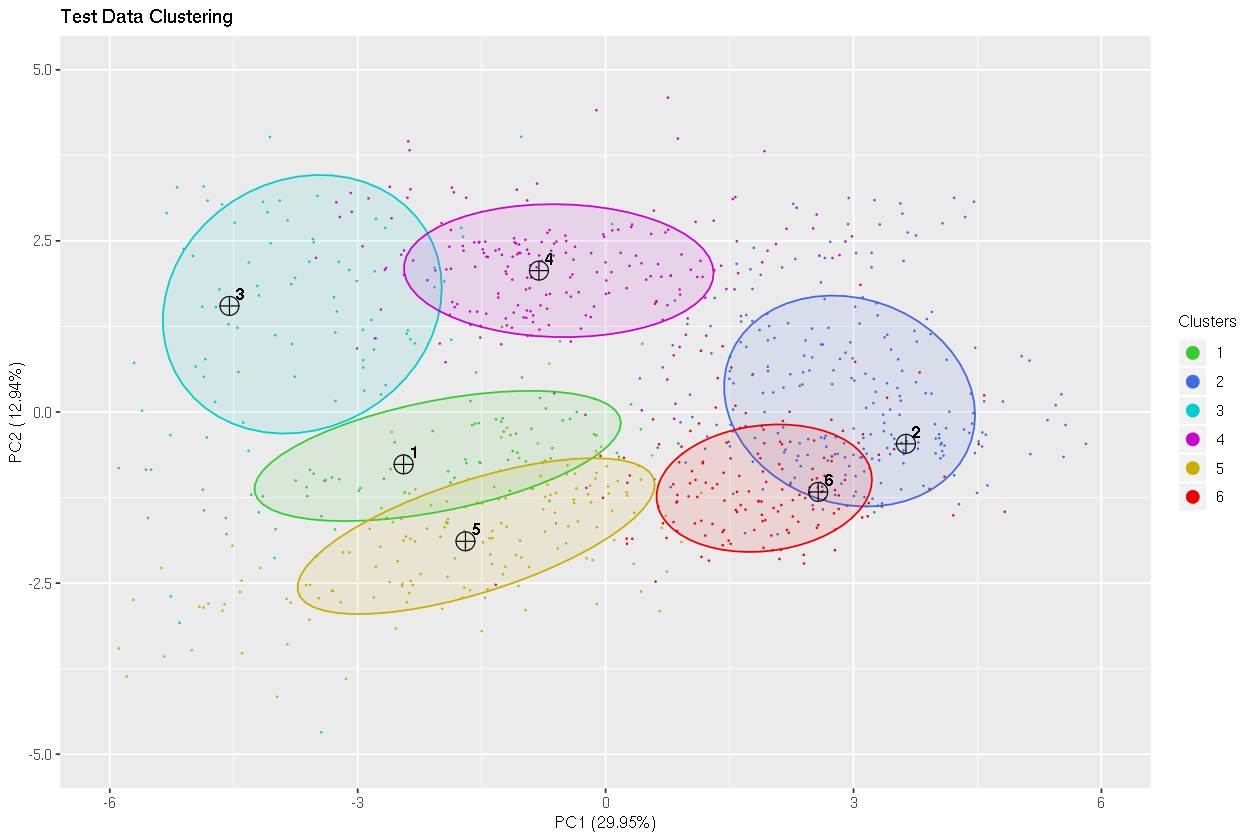

In [14]:
# Plot PC1 x PC2
sel.cols=c("limegreen", "royalblue", "cyan3", "magenta3", "gold3", "red2")
set_plot_dimensions(1.5, 1)
plot.clus.rpca(robpca.model, cluster.model, data=trans.new.data, cluster=pred.clusters,
               title="Test Data Clustering", col=sel.cols, alpha=0.1, level=0.7,
               comp1=1, comp2=2, xlim=c(-6, 6), ylim=c(-5, 5))

Warning message:
“Removed 16 rows containing non-finite values (stat_ellipse).”
Warning message:
“Removed 16 rows containing missing values (geom_point).”


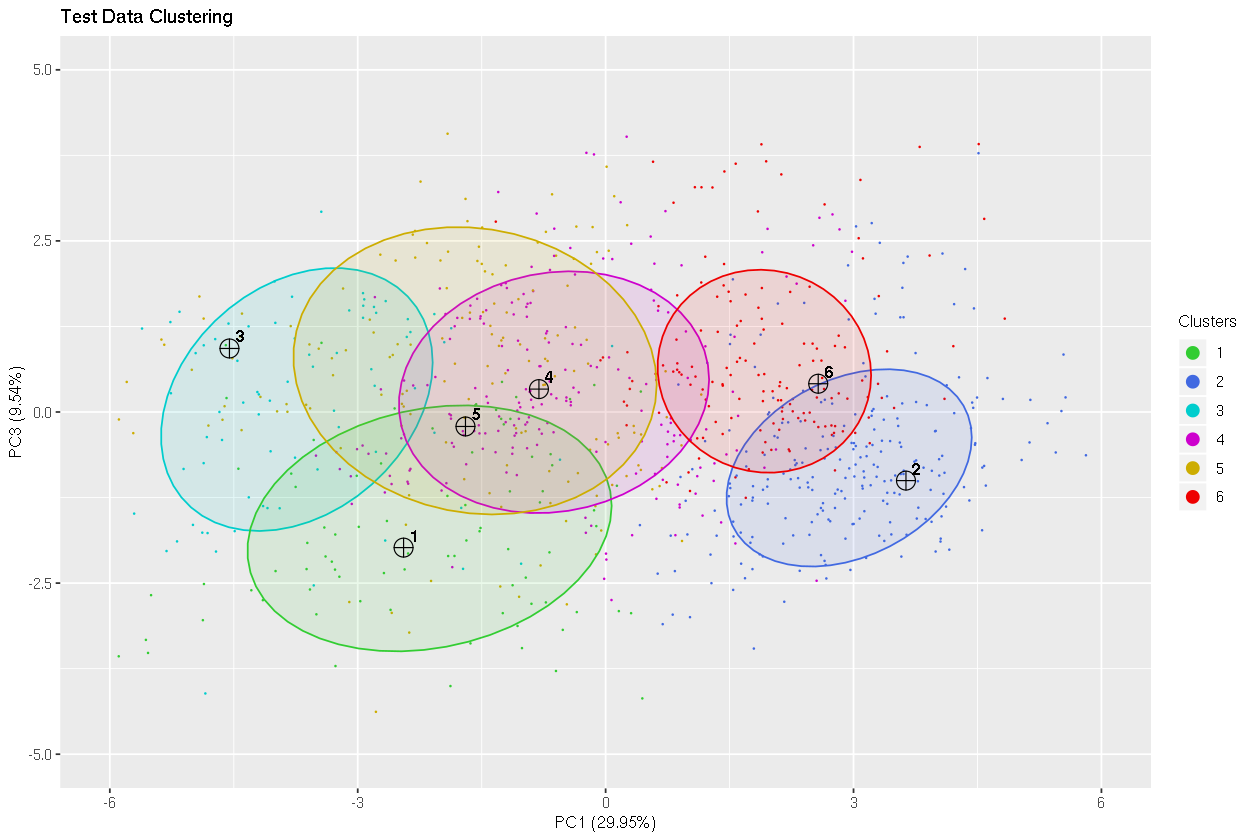

In [15]:
# Plot PC1 and PC3
sel.cols=c("limegreen", "royalblue", "cyan3", "magenta3", "gold3", "red2")
set_plot_dimensions(1.5, 1)
plot.clus.rpca(robpca.model, cluster.model, data=trans.new.data, cluster=pred.clusters,
               title="Test Data Clustering", col=sel.cols, alpha=0.1, level=0.7,
               comp1=1, comp2=3, xlim=c(-6, 6), ylim=c(-5, 5))

## Outlier detection I (global outlier)
<i>By using robust methods, we have managed to construct a clustering system and perform its diagnostics, in the presence of outliers. However, outliers may or may not be welcome in the new data, especially when their cluster allocation may need to be questioned. So we must be able to detect outliers in new data! This can be achieved using a clustering model itself and identifying observations, which are furthest away from all medoids (GSS - global sum-of-squares of distance to medoids).</i>

In [16]:
# Function which applies pam model to new data and calculates medoid GSS distance
apply.pam <- function(clus, newdata) apply(newdata, 1, 
                   function(x, c=clus) sum(colSums((t(c$medoids)-x)^2)))
pred.clust.dist <- scale(apply.pam(cluster.model, newdata=trans.new.data))
head(pred.clust.dist, 5)
cat('Number of clustered observations: ', length(pred.clust.dist), '\n')

527258020,-0.502029089
528172060,-0.251295865
534127230,-0.346477313
902100030,0.002538039
534125210,0.054895641


Number of clustered observations:  930 


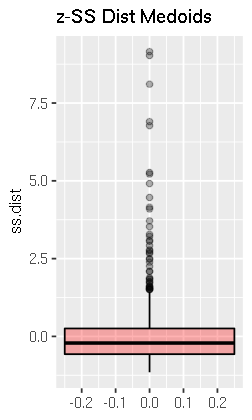

In [17]:
# Distribution of sums of squared distances to medoids
set_plot_dimensions(0.3, 0.5)
ggplot(data.frame(ss.dist=pred.clust.dist), aes(y=ss.dist)) + 
  geom_boxplot(width=0.5, col="black", fill="red", alpha=0.3) +
  ggtitle("z-SS Dist Medoids")

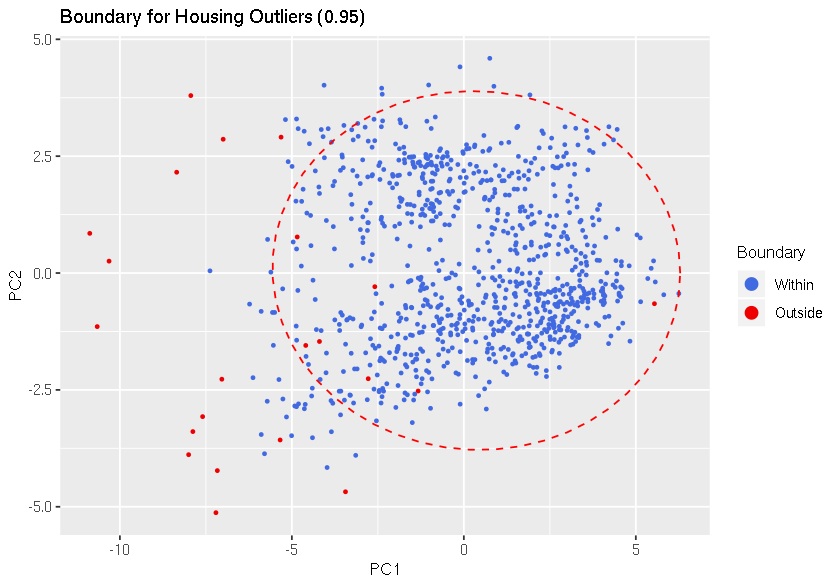

In [18]:
# Plot outliers

# Outcless = 1 (normal), 2 (outlier)
outliers <- data.frame(outclass=as.integer(abs(pred.clust.dist) > 2.5)+1)

set_plot_dimensions(1.5, 1)
plot.outl.in.pca(robpca.model, data=trans.new.data, outl=outliers$outclass,
               col=c("royalblue", "red2"), alpha=0.2, level=0.95, size=1.2,
               title="Boundary for Housing Outliers (0.95)", comp1=1, comp2=2)

<i>Note the outliers in the "middle" of the data boundary - checking higher PC dimensions (e.g. PC1xPC3) will ensure that these data points are indeed outside the boundary.<br><br>
    Another way of dealing with outliers would be to use the "local outlier detection". For example we could declare all cluster members far from the medoid or outside the cluster boundary as outliers. It should be noted that such an approach would generate outliers which are "visually" in the middle of the dataset boundaries.</i>